# Distributions

## COMPAS
* HP (https://compas.science/)
* GitHub (https://compas.readthedocs.io/en/latest/)
* Patameter List (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification.html)
    * Stellar Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-stellar.html)
    * Binary Properties (https://compas.readthedocs.io/en/latest/pages/User%20guide/COMPAS%20output/standard-logfiles-record-specification-binary.html)

## Import Modules

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from scipy import stats
from scipy.stats import gaussian_kde

import pickle
import bisect
import os
import glob

import h5py as h5
from astropy.table import  unique, vstack, Table, Column, join
import astropy.units as u
from astropy import constants as const
from scipy.stats import norm as NormDist
from matplotlib.colors import Normalize
from matplotlib.colors import LogNorm

# Chosen cosmology 
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value

##############################
# This path points to the COMPAS functions in your local folder,
# I've redefined most in this notebook anyway, but I was lazy w.r.t the kroupa IMF etc. 
sys.path.insert(0,'/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/')

import FastCosmicIntegration as COMPAS_sfrd
import ClassCOMPAS as COMPAS_class

from importlib import reload  # Python 3.4+
reload(COMPAS_sfrd)

<module 'FastCosmicIntegration' from '/home/jovyan/home/code/COMPAS/compas_python_utils/CosmicIntegration_vanSon/FastCosmicIntegration.py'>

## PLOT setttings

In [2]:
######################################
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans']})
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

## Constant Parameters

In [3]:
# physical constants
G = 6.67428e-8 # Gravitational Constant (dyn cm^2 / g^2)
c = 2.99792458e10 # Light Speed (cm/s)

# mass [g]
mp =  1.673e-24 # Proton Mass
me = 9.1093837015e-28 # Electron Mass
 
# solar quantities
sigma = 5.67e-5 #Stefan-Boltzmann Constant (erg/cm^2/K^4/s)
Msun = 1.99e33 # Solar Mass [g]
Lsun = 3.839e33 # Solar Luminosity [erg/s]
Rsun = 6.955e10 # Solar Radius [cm]
Tsun = (Lsun / (4*np.pi*Rsun**2*sigma))**0.25 # Solar Photospheric Temperature [K]
Zsun = 0.014 # Solar Metallicity

# time [s]
hr = 3600.0 # Hour
day = 24.0*hr # Day
yr =  365.25*day # Year
Myr = 1e6*yr # Mega Year
Gyr = 1e9*yr # Giga Year

# distance [cm]
pc = 3.086e18 # Parsec
Mpc = 1e6*pc # Mega Parsec
Gpc = 1e9*pc # Giga Parsec

q = 4.80320425e-10 
r_e = (q**2/(me*c**2))
sigT = (8.*np.pi/3.) * r_e**2

# frequency [Hz]
MHz = 1e6 # Mega Hertz
GHz = 1e9 # Giga Hertz

# radiation [erg/s/cm^2/Hz]
Jy = 1e-23 # Jansky
mJy = 1e-6 * Jy # Milli Jansky
uJy = 1e-9 * Jy # Micro Jansky

## Path Setting & Data Reading

In [4]:
COMPAS_result_dir = '/home/jovyan/COMPAS_02.35.02_N1e7_Fiducial_AllDCO_AIS/'
pathToData = COMPAS_result_dir+'MainRun/COMPAS_Output_wWeights.h5'

# Read data and put in astropy table
File        = h5.File(pathToData ,'r')
SYS_keys  = ['SEED', 'mixture_weight', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Metallicity@ZAMS(1)', 'CE_Event_Counter', 
             'Merger', 'Optimistic_CE', 'Immediate_RLOF>CE']
SYS = Table()
for key in SYS_keys:
    SYS[key] = File['BSE_System_Parameters'][key][()] 
File.close()

with open('./sampling_data/mt_edd100.pkl', 'rb') as file:
    mt_edd100 = pickle.load(file)
    
with open('./sampling_data/ce_edd100.pkl', 'rb') as file:
    ce_edd100 = pickle.load(file)
    
SYS_mt = SYS[np.in1d(SYS['SEED'], mt_edd100['SEED'])]
SYS_ce = SYS[np.in1d(SYS['SEED'], ce_edd100['SEED'])]

mt = join(SYS_mt, mt_edd100, keys='SEED')
ce = join(SYS_ce, ce_edd100, keys='SEED')

mt_mask_Tnan = ~np.isnan(mt['Teff(D)>MT'])
ce_mask_Tnan = ~np.isnan(ce['Teff(D)>MT'])
mt = mt[mt_mask_Tnan]
ce = ce[ce_mask_Tnan]

In [5]:
save_dir = './figures/distribution/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

## Compute the Star Forming Mass

In [6]:
def find_star_forming_mass_per_binary_sampling(m1=0.01, m2=0.08, m3=0.5, m4=200.0, a12=0.3, a23=1.3, a34=2.3,
                                               primary_mass_inverse_CDF=None, mass_ratio_inverse_CDF=None, SAMPLES=20000000, 
                                               binaryFraction = 0.7, Mlower = 10.* u.Msun, Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun):
    """
        Calculate the star forming mass evolved for each binary in the file.
        This function does this by sampling from the IMF and mass ratio distributions

        Args:
            mi                       --> [float]    masses at which to transition the slope of the IMF (ignored if primary_mass_inverse_CDF is not None)
            aij                      --> [float]    slope of the IMF between mi and mj (ignored if primary_mass_inverse_CDF is not None)
            primary_mass_inverse_CDF --> [function] a function that computes the inverse CDF functoin for the primary mass distribution
                                                    this defaults to the Kroupa IMF (which can be varied using mi, aij)
            mass_ratio_inverse_CDF   --> [function] a function that computes the inverse CDF function for the mass ratio distribution
                                                    this defaults to assuming a uniform mass ratio on [0, 1]
            SAMPLES                  --> [int]      number of samples to draw when creating a mock universe
            binaryFraction           --> [int]      Asusmed binary fraction, default = 0.7
            Mlower                   --> [int]      Minimum primary mass sampled by COMPAS default = 10 
            Mupper                   --> [int]      Maximum primary mass sampled by COMPAS default = 150
            m2_min                  --> [int]      Minimum secondary mass sampled by COMPAS default = 0.1
    """
    # if primary mass inverse CDF is None, assume the Kroupa IMF
    if primary_mass_inverse_CDF is None:
        primary_mass_inverse_CDF = lambda U: COMPAS_class.inverse_CDF_IMF(U, m1=m1, m2=m2, m3=m3, m4=m4, a12=a12, a23=a23, a34=a34)

    # if mass ratio inverse CDF function is None, assume uniform
    if mass_ratio_inverse_CDF is None:
        mass_ratio_inverse_CDF = lambda q: q

    # randomly sample a large number of masses from IMF, mass ratios from supplied function, binary for boolean
    primary_mass = primary_mass_inverse_CDF(np.random.rand(SAMPLES)) * u.Msun
    mass_ratio = mass_ratio_inverse_CDF(np.random.rand(SAMPLES))
    binary = np.random.rand(SAMPLES)

    # only fbin fraction of stars have a secondary (in a binary)
    binary_mask = binary < binaryFraction

    # assign each a random secondary mass, default 0 because single stars have m2=0 (surprisingly :P)
    secondary_mass = np.zeros(SAMPLES) * u.Msun
    secondary_mass[binary_mask] = primary_mass[binary_mask] * mass_ratio[binary_mask]

    # find the total mass of the whole population
    total_mass = np.sum(primary_mass) + np.sum(secondary_mass)

    # apply the COMPAS cuts on primary and secondary mass
    primary_mask = np.logical_and(primary_mass >= Mlower, primary_mass <= Mupper)
    secondary_mask = secondary_mass > m2_min
    full_mask = np.logical_and(primary_mask, secondary_mask)

    # find the total mass with COMPAS cuts
    total_mass_COMPAS = np.sum(primary_mass[full_mask]) + np.sum(secondary_mass[full_mask])

    # use the totals to find the ratio and return the average mass as well
    f_mass_sampled = total_mass_COMPAS / total_mass
    average_mass_COMPAS = total_mass_COMPAS / len(primary_mass[full_mask])

    # find the average star forming mass evolved per binary in the Universe
    mass_evolved_per_binary = average_mass_COMPAS / f_mass_sampled
    
    return mass_evolved_per_binary

In [7]:
n_systems = len(SYS['SEED'])
M1_min    = np.min(SYS['Mass@ZAMS(1)'][()]) #minimum ZAMS mass simulated

mass_evolved_per_binary = find_star_forming_mass_per_binary_sampling(binaryFraction = 0.7, Mlower = M1_min* u.Msun, 
                                                                     Mupper = 150 * u.Msun, m2_min = 0.1 * u.Msun)
print('mass_evolved_per_binary', mass_evolved_per_binary)

Average_SF_mass_needed = (mass_evolved_per_binary * n_systems)
print('Average_SF_mass_needed', Average_SF_mass_needed)

mass_evolved_per_binary 101.02753393383492 solMass
Average_SF_mass_needed 1010275339.3383492 solMass


### scale the Universe mass from $10^9$ to $10^{12}$ (c.f., per galaxy)

In [8]:
mass_scaling_factor = 10**12*u.Msun/Average_SF_mass_needed

## Star Formation Rate Density (SFRD)

SFRD is star forming mass per unit volume per year. We assume the analysical formalism propoersed by Madau & Dickinson 2014 (https://ui.adsabs.harvard.edu/abs/2014ARA%26A..52..415M/abstract)
$$
{\rm SFRD} = \frac{d^2 M}{dtdV} = a \frac{(1+z)^b}{1 + \left(\frac{1+z}{c}\right)^{d}} {\rm ~[M_{\odot}/yr/Mpc^{3}]},
$$
where $z$ is the redshift, and $a$, $b$, $c$, and $d$ is a fitting parameters. Fiducially, the parameters are $(a, b, c, d) = (0.017, 1.487, 4.442, 5.886)$

In [9]:
def find_sfr(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    """
        Calculate the star forming mass per unit volume per year following
        Neijssel+19 Eq. 6, using functional form of Madau & Dickinson 2014

        Args:
            redshifts --> [list of floats] List of redshifts at which to evaluate the sfr

        Returns:
            sfr       --> [list of floats] Star forming mass per unit volume per year for each redshift
    """
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

In [10]:
redshifts = np.linspace(0,1,100)
sfr = find_sfr(redshifts)

## Metallicity Distribution

Calculate the distribution of metallicities at different redshifts using a log skew normal distribution.

* Mean Metallicity
$$
\langle Z \rangle = \mu(z) = \mu_{0} \times 10^{\mu_{z}\cdot z}
$$
* Scale of the metallicity distribution with redshift (in van Son et al. 2023, $\sigma \to \omega$ ?)
$$
\sigma = \sigma_{0}\times 10^{\sigma_{z}\cdot z}
$$
* Parameter $\beta$
$$
\beta = \frac{\alpha}{\sqrt{1 + \alpha^2}}
$$
* Standard log-normal distribution (PDF)
$$
\phi\left(\frac{\ln Z-\xi}{\sigma}\right) = \frac{1}{\sqrt{2 \pi}} \exp \left\{-\frac{1}{2}\left(\frac{\ln Z-\xi}{\sigma}\right)^2\right\}
$$
* Cumulative of the log-normal distribution (CDF)
$$
\Phi\left(\alpha \frac{\ln Z-\xi}{\sigma}\right) = \frac{1}{2}\left[1+\operatorname{erf}\left\{\alpha \frac{\ln Z-\xi}{\sigma \sqrt{2}}\right\}\right]
$$ 
* The redshift dependence of the location
$$
\xi(z) = \log\left( \frac{\langle Z \rangle}{2\Phi(\beta \sigma)} \right) - \frac{\sigma^2}{2}
$$
* Log metallicity distribution
$$
\frac{dP(Z, z)}{d\log Z} = \frac{2}{\sigma} \times \phi\left(\frac{\ln Z-\xi}{\sigma}\right) \times \Phi\left(\alpha \frac{\ln Z-\xi}{\sigma}\right)
$$ 


In [11]:
def find_metallicity_distribution(redshifts = 0,  min_logZ_COMPAS = np.log(0.0001), max_logZ_COMPAS = np.log(0.03),
                                  # mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
                                  mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):

    #     redshifts, np.log(0.0001),# np.log(0.03),
    #                                   mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0,
    #                                   min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01):
    # mu0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048, alpha =-1.767,

    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    =  0.035    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.25    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 0.39     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.00     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = 0.00    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """ 
    ##################################
    # Log-Linear redshift dependence of sigma
    sigma = sigma_0* 10**(sigma_z*redshifts)
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu0 * 10**(muz * redshifts) 
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = NormDist.cdf(beta * sigma) 
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI )  ) 

    ##################################
    # create a range of metallicities (thex-values, or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)


    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * NormDist.pdf((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * NormDist.cdf(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, metallicities, p_draw_metallicity

In [12]:
dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(redshifts)

## Mass Distribution

In [13]:
mass_bins = np.arange(0, 150, 2)

hist_SYS, bin_edge = np.histogram(SYS['Mass@ZAMS(1)'],bins=mass_bins, weights=mass_scaling_factor*SYS['mixture_weight'])
hist_mt, bin_edge = np.histogram(mt['Mass@ZAMS(1)'],bins=mass_bins, weights=mass_scaling_factor*mt['mixture_weight'])
hist_ce, bin_edge = np.histogram(ce['Mass@ZAMS(1)'],bins=mass_bins, weights=mass_scaling_factor*ce['mixture_weight'])

mass_center_bins = (bin_edge[:-1] + bin_edge[1:])/2.

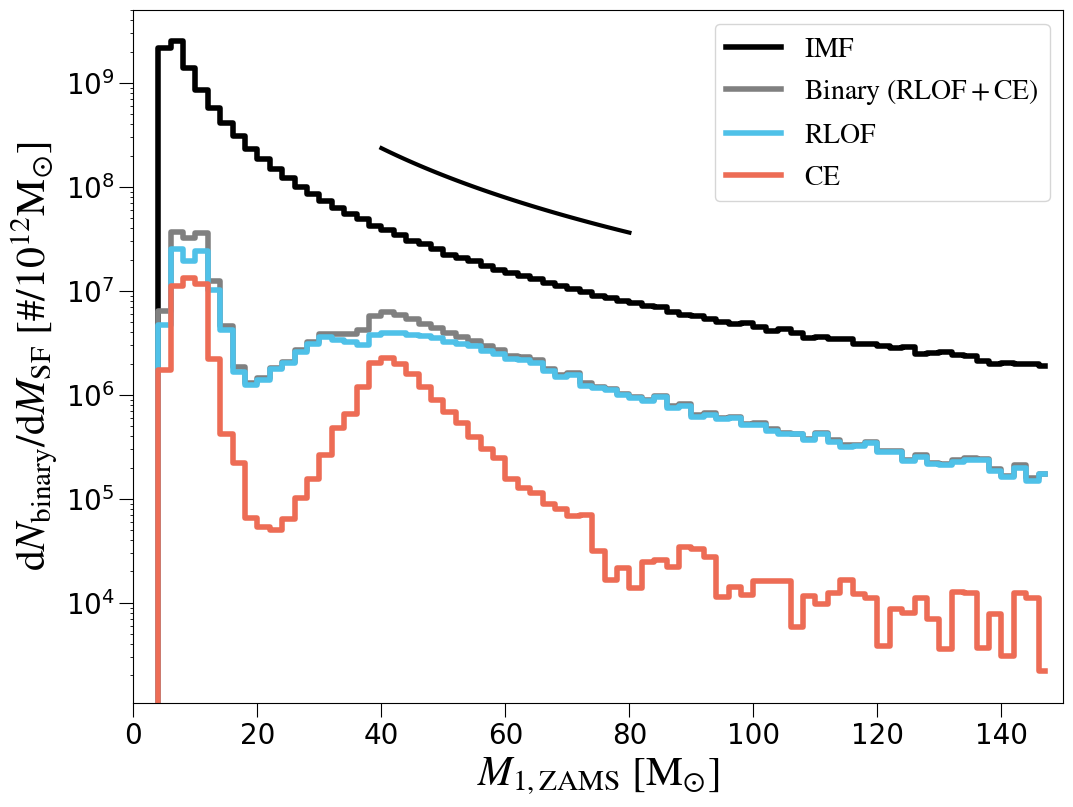

In [14]:
color_list = ['black', 'grey', '#4FC1E8', '#ed6c55', '#A0D568', '#FFCE54', '#6e6e6e']

# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_SYS, where='mid', color=color_list[0], lw=4, label='$\mathrm{IMF}$',)
ax.step(mass_center_bins, hist_mt+hist_ce, where='mid', color=color_list[1], lw=4, label='$\mathrm{Binary \ (RLOF+CE)}$')
ax.step(mass_center_bins, hist_mt, where='mid', color=color_list[2], lw=4, label='$\mathrm{RLOF}$')
ax.step(mass_center_bins, hist_ce, where='mid', color=color_list[3], lw=4, label='$\mathrm{CE}$')

x = np.linspace(40, 80, 100)
ax.plot(x, 5e12*x**(-2.7), lw=3, color='black')

########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0, 150])

plt.xlabel(r'$M_{\mathrm{1, ZAMS}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathrm{d} N_{\mathrm{binary}} / \mathrm{d}M_{\mathrm{SF}} \ \mathrm{[\# /10^{12}M_{\odot}]}$', fontsize = 30)

plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize = 20, ncol=1)
plt.savefig(save_dir+'mass_distribution_ZAMS.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [15]:
hist_mt_CO, bin_edge = np.histogram(mt['Mass(A)<MT'],bins=mass_bins, weights=mass_scaling_factor*mt['mixture_weight'])
hist_ce_CO, bin_edge = np.histogram(ce['Mass(A)<MT'],bins=mass_bins, weights=mass_scaling_factor*ce['mixture_weight'])

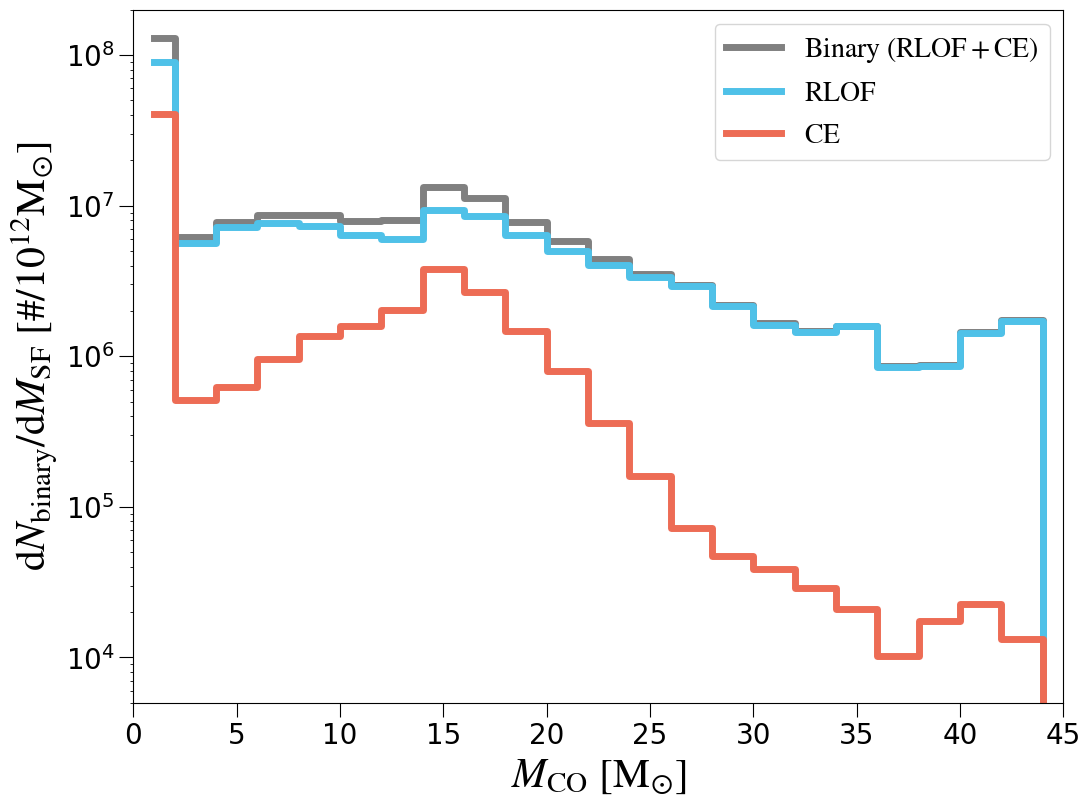

In [16]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

# ax.step(mass_center_bins, hist_SYS, where='mid', color=color_list[0], lw=5)
ax.step(mass_center_bins, hist_mt_CO+hist_ce_CO, where='mid', color=color_list[1], lw=5, label=r'$\mathrm{Binary \ (RLOF+CE)}$')
ax.step(mass_center_bins, hist_mt_CO, where='mid', color=color_list[2], lw=5, label='$\mathrm{RLOF}$')
ax.step(mass_center_bins, hist_ce_CO, where='mid', color=color_list[3], lw=5, label='$\mathrm{CE}$')

########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 45])
ax.set_ylim([5e3, 2e8])

plt.xlabel(r'$M_{\mathrm{CO}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathrm{d} N_{\mathrm{binary}} / \mathrm{d}M_{\mathrm{SF}} \ \mathrm{[\# /10^{12}M_{\odot}]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 20, ncol=1)
plt.savefig(save_dir+'mass_distribution_CO.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [17]:
hist_mt_bD, bin_edge = np.histogram(mt['Mass(D)<MT'],bins=mass_bins, weights=mass_scaling_factor*mt['mixture_weight'])
hist_ce_bD, bin_edge = np.histogram(ce['Mass(D)<MT'],bins=mass_bins, weights=mass_scaling_factor*ce['mixture_weight'])

hist_mt_aD, bin_edge = np.histogram(mt['Mass(D)>MT'],bins=mass_bins, weights=mass_scaling_factor*mt['mixture_weight'])
hist_ce_aD, bin_edge = np.histogram(ce['Mass(D)>MT'],bins=mass_bins, weights=mass_scaling_factor*ce['mixture_weight'])

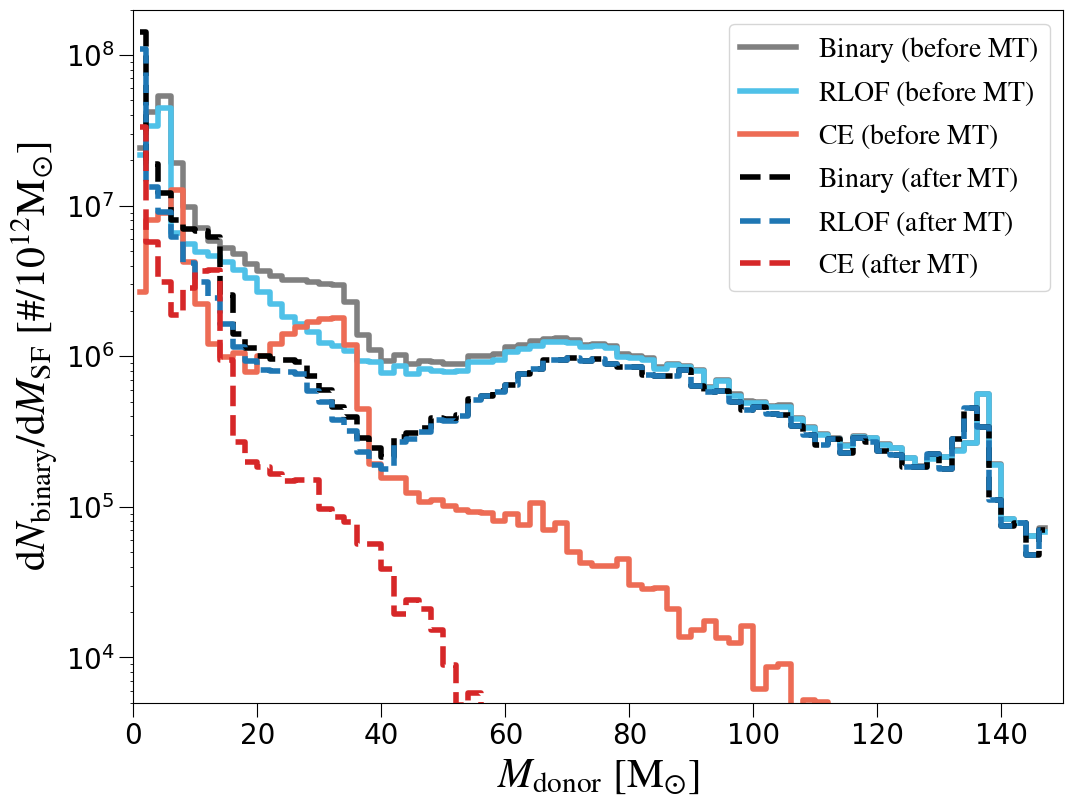

In [18]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_mt_bD+hist_ce_bD, where='mid', color=color_list[1], label=r'$\mathrm{Binary \ (before \ MT)}$', lw=4)
ax.step(mass_center_bins, hist_mt_bD, where='mid', color=color_list[2], label='$\mathrm{RLOF \ (before \ MT)}$', lw=4)
ax.step(mass_center_bins, hist_ce_bD, where='mid', color=color_list[3], label='$\mathrm{CE \ (before \ MT)}$', lw=4)

ax.step(mass_center_bins, hist_mt_aD+hist_ce_aD, where='mid', color='black', ls='dashed', label=r'$\mathrm{Binary \ (after \ MT)}$', lw=4)
ax.step(mass_center_bins, hist_mt_aD, where='mid', color='tab:blue', ls='dashed', label='$\mathrm{RLOF \ (after \ MT)}$', lw=4)
ax.step(mass_center_bins, hist_ce_aD, where='mid', color='tab:red', ls='dashed', label='$\mathrm{CE \ (after \ MT)}$', lw=4)

########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0, 150])
ax.set_ylim([5e3, 2e8])

plt.xlabel(r'$M_{\mathrm{donor}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathrm{d} N_{\mathrm{binary}} / \mathrm{d}M_{\mathrm{SF}} \ \mathrm{[\# /10^{12}M_{\odot}]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 20, ncol=1)
plt.savefig(save_dir+'mass_distribution_D.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [19]:
# ratio_bins = np.arange(0.0, 50, 0.1)

# hist_ratio_mt_bD, ratio_bin_edge = np.histogram(mt['Mass(D)<MT']/mt['Mass(A)<MT'], bins=ratio_bins, weights=mass_scaling_factor*mt['mixture_weight'])
# hist_ratio_ce_bD, ratio_bin_edge = np.histogram(ce['Mass(D)<MT']/ce['Mass(A)<MT'], bins=ratio_bins, weights=mass_scaling_factor*ce['mixture_weight'])

# hist_ratio_mt_aD, ratio_bin_edge = np.histogram(mt['Mass(D)>MT']/mt['Mass(A)>MT'],bins=ratio_bins, weights=mass_scaling_factor*mt['mixture_weight'])
# hist_ratio_ce_aD, ratio_bin_edge = np.histogram(ce['Mass(D)>MT']/ce['Mass(A)>MT'],bins=ratio_bins, weights=mass_scaling_factor*ce['mixture_weight'])

# ratio_center_bins = (ratio_bin_edge[:-1] + ratio_bin_edge[1:])/2.

In [20]:
# # Then plot it!
# ####################
# fig, ax = plt.subplots(figsize = (12,9))

# ax.step(ratio_center_bins, hist_ratio_mt_bD+hist_ratio_ce_bD, where='mid', color=color_list[1], label=r'$\mathrm{Binary \ (before MT)}$', lw=3)
# ax.step(ratio_center_bins, hist_ratio_mt_bD, where='mid', color=color_list[2], label='$\mathrm{RLOF \ (before MT)}$', lw=3)
# ax.step(ratio_center_bins, hist_ratio_ce_bD, where='mid', color=color_list[3], label='$\mathrm{CE \ (before MT)}$', lw=3)

# ax.step(ratio_center_bins, hist_ratio_mt_aD+hist_ratio_ce_aD, where='mid', color=color_list[1], label=r'$\mathrm{Binary \ (after MT)}$', lw=3, ls='dashed')
# ax.step(ratio_center_bins, hist_ratio_mt_aD, where='mid', color=color_list[2], label='$\mathrm{RLOF \ (after MT)}$', lw=3, ls='dashed')
# ax.step(ratio_center_bins, hist_ratio_ce_aD, where='mid', color=color_list[3], label='$\mathrm{CE \ (after MT)}$', lw=3, ls='dashed')

# ########
# ax.tick_params(axis='both', which='major', labelsize=20, size=10)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# plt.locator_params(axis='y', nbins=6)

# ax.set_xlim([0, 45])
# # ax.set_ylim([5e3, 2e8])

# plt.xlabel(r'$q \equiv M_{\mathrm{donor}} / M_{\mathrm{CO}}$', fontsize = 30)
# plt.ylabel(r'$\mathrm{d} N_{\mathrm{binary}} / \mathrm{d}M_{\mathrm{SF}} \ \mathrm{[\# /10^{12}M_{\odot}]}$', fontsize = 30)

# plt.yscale('log')
# plt.legend(fontsize = 20, ncol=1)
# plt.savefig('./Fig_paper/mass_distribution_ratio.pdf', bbox_inches='tight', pad_inches=0.1)
# plt.show()

## Rate Distribution

In [21]:
def find_formation_rates(n_binaries, redshifts, n_formed, dPdlogZ, metallicities, p_draw_metallicity,
                         COMPAS_metallicites, COMPAS_weights=None):
    """
        Find both the formation and merger rates for each binary at each redshift

        Args:
            n_binaries          --> [int]            Number of DCO binaries in the arrays
            redshifts           --> [list of floats] Redshifts at which to evaluate the rates
            n_formed            --> [float]          Binary formation rate (number of binaries formed per year per cubic Gpc) represented by each simulated COMPAS binary
            dPdlogZ             --> [2D float array] Probability of getting a particular logZ at a certain redshift
            metallicities       --> [list of floats] Metallicities at which dPdlogZ is evaluated; if this is None, assume that metallicity weighting is 1 (corresponds to all SFR happening at one fixed metallicity)
            p_draw_metallicity  --> [float]          Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
            COMPAS_metallicites --> [list of floats] Metallicity of each binary in COMPAS data
            COMPAS_weights      --> [list of floats] Adaptive sampling weights for each binary in COMPAS data (defaults to all 1s for unweighted samples)

        Returns:
            formation_rate      --> [2D float array] Formation rate for each binary at each redshift
    """
    # check if weights were provided, if not use uniform weights
    if COMPAS_weights is None:
        COMPAS_weights = np.ones(n_binaries)

    # initialise rates to zero
    n_redshifts = len(redshifts)
    formation_rate = np.zeros(shape=(n_binaries, n_redshifts))

    # go through each binary in the COMPAS data
    for i in range(n_binaries):
        # if metallicities array is None, assume all SFR happened at one fixed metallicity
        if metallicities is None :
            formation_rate[i, :] = n_formed * COMPAS_weights[i]
        # calculate formation rate (see Neijssel+19 Section 4) - note this uses dPdlogZ for *closest* metallicity
        else:
            formation_rate[i, :] = n_formed * dPdlogZ[:, np.digitize(COMPAS_metallicites[i], metallicities)] / p_draw_metallicity * COMPAS_weights[i]

    return formation_rate

In [22]:
# n_SYS = len(SYS)
n_mt = len(mt)
n_ce = len(ce)
n_formed = sfr / Average_SF_mass_needed.value

mt_formation_rate = find_formation_rates(n_mt, redshifts, n_formed, dPdlogZ, metallicities, p_draw_metallicity,
                                         mt['Metallicity@ZAMS(1)'], mt['mixture_weight'])
ce_formation_rate = find_formation_rates(n_ce, redshifts, n_formed, dPdlogZ, metallicities, p_draw_metallicity,
                                         ce['Metallicity@ZAMS(1)'], ce['mixture_weight'])

In [23]:
mt['rate_z0'] = mt_formation_rate[:, 0]
ce['rate_z0'] = ce_formation_rate[:, 0]

mt['rate_z1'] = mt_formation_rate[:, len(redshifts)-1]
ce['rate_z1'] = ce_formation_rate[:, len(redshifts)-1]

In [24]:
hist_rate_z0_mt, bin_edge = np.histogram(mt['Mass@ZAMS(1)'],bins=mass_bins, weights=mt['rate_z0'])
hist_rate_z0_ce, bin_edge = np.histogram(ce['Mass@ZAMS(1)'],bins=mass_bins, weights=ce['rate_z0'])

hist_rate_z1_mt, bin_edge = np.histogram(mt['Mass@ZAMS(1)'],bins=mass_bins, weights=mt['rate_z1'])
hist_rate_z1_ce, bin_edge = np.histogram(ce['Mass@ZAMS(1)'],bins=mass_bins, weights=ce['rate_z1'])


hist_rate_z0_mt_A, bin_edge = np.histogram(mt['Mass(A)<MT'],bins=mass_bins, weights=mt['rate_z0'])
hist_rate_z0_ce_A, bin_edge = np.histogram(ce['Mass(A)<MT'],bins=mass_bins, weights=ce['rate_z0'])

hist_rate_z1_mt_A, bin_edge = np.histogram(mt['Mass(A)>MT'],bins=mass_bins, weights=mt['rate_z1'])
hist_rate_z1_ce_A, bin_edge = np.histogram(ce['Mass(A)>MT'],bins=mass_bins, weights=ce['rate_z1'])


hist_rate_z0_mt_bD, bin_edge = np.histogram(mt['Mass(D)<MT'],bins=mass_bins, weights=mt['rate_z0'])
hist_rate_z0_ce_bD, bin_edge = np.histogram(ce['Mass(D)<MT'],bins=mass_bins, weights=ce['rate_z0'])

hist_rate_z1_mt_bD, bin_edge = np.histogram(mt['Mass(D)>MT'],bins=mass_bins, weights=mt['rate_z1'])
hist_rate_z1_ce_bD, bin_edge = np.histogram(ce['Mass(D)>MT'],bins=mass_bins, weights=ce['rate_z1'])


hist_rate_z0_mt_aD, bin_edge = np.histogram(mt['Mass(D)<MT'],bins=mass_bins, weights=mt['rate_z0'])
hist_rate_z0_ce_aD, bin_edge = np.histogram(ce['Mass(D)<MT'],bins=mass_bins, weights=ce['rate_z0'])

hist_rate_z1_mt_aD, bin_edge = np.histogram(mt['Mass(D)>MT'],bins=mass_bins, weights=mt['rate_z1'])
hist_rate_z1_ce_aD, bin_edge = np.histogram(ce['Mass(D)>MT'],bins=mass_bins, weights=ce['rate_z1'])

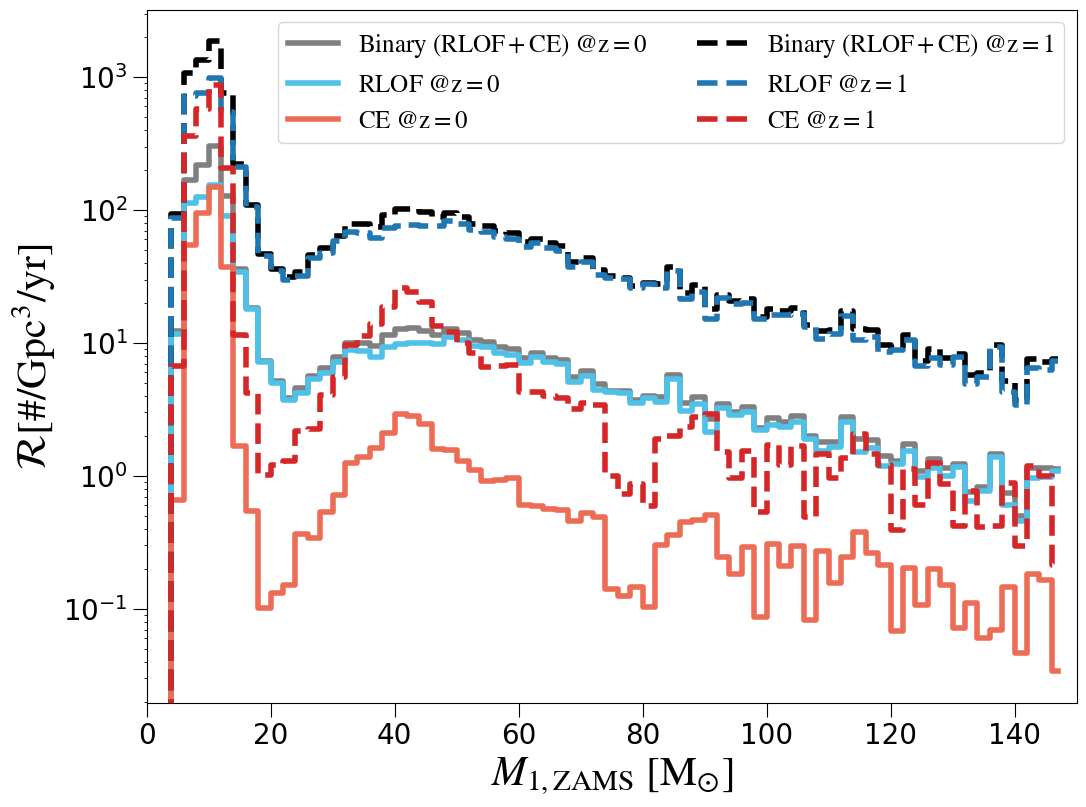

In [25]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_rate_z0_mt+hist_rate_z0_ce, where='mid', color=color_list[1], 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_mt, where='mid', color=color_list[2], 
        label='$\mathrm{RLOF \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_ce, where='mid', color=color_list[3], 
        label='$\mathrm{CE \ @z=0}$', lw=4)


ax.step(mass_center_bins, hist_rate_z1_mt+hist_rate_z1_ce, where='mid', color='black', 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_mt, where='mid', color='tab:blue', 
        label='$\mathrm{RLOF \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_ce, where='mid', color='tab:red', 
        label='$\mathrm{CE \ @z=1}$', lw=4, ls='dashed')


########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 150])
# ax.set_ylim([0.1, 1e4])

plt.xlabel(r'$M_{\mathrm{1, ZAMS}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{R} \mathrm{[\# /Gpc^3 / yr]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 18, ncol=2)
plt.savefig(save_dir+'rate_distribution_zams.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

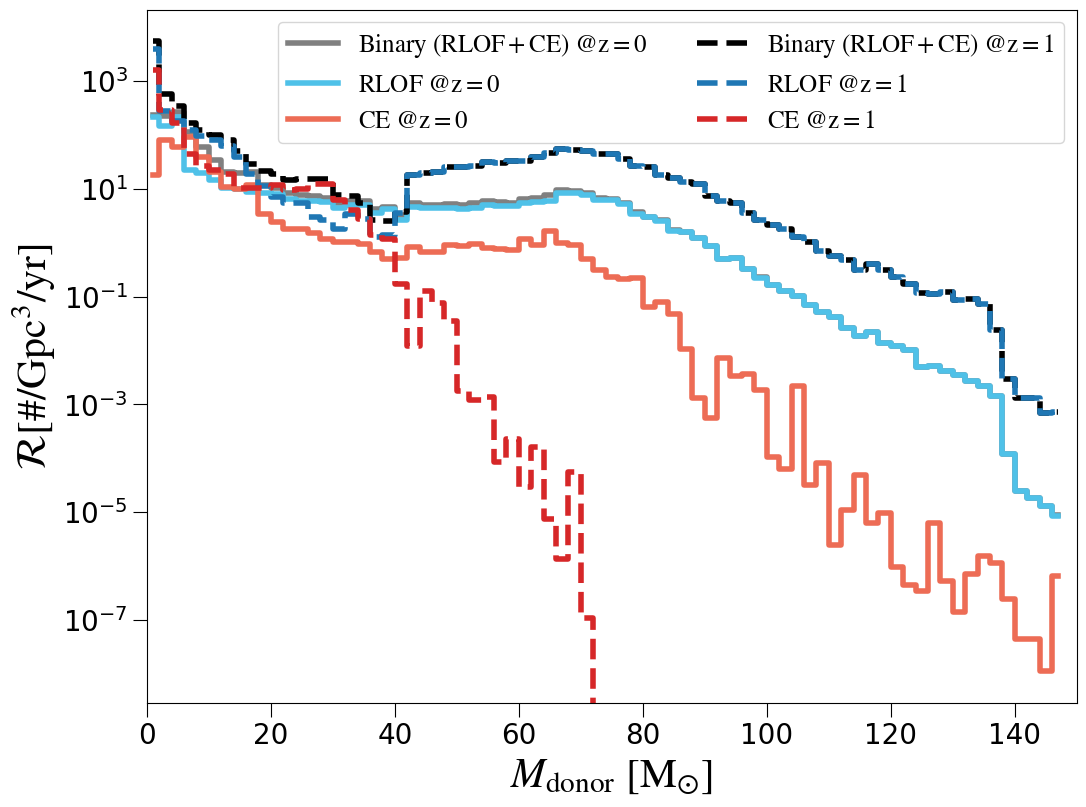

In [26]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_rate_z0_mt_bD+hist_rate_z0_ce_bD, where='mid', color=color_list[1], 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_mt_bD, where='mid', color=color_list[2], 
        label='$\mathrm{RLOF \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_ce_bD, where='mid', color=color_list[3], 
        label='$\mathrm{CE \ @z=0}$', lw=4)


ax.step(mass_center_bins, hist_rate_z1_mt_bD+hist_rate_z1_ce_bD, where='mid', color='black', 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_mt_bD, where='mid', color='tab:blue', 
        label='$\mathrm{RLOF \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_ce_bD, where='mid', color='tab:red', 
        label='$\mathrm{CE \ @z=1}$', lw=4, ls='dashed')


########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 150])
# ax.set_ylim([5e3, 2e9])

plt.xlabel(r'$M_{\mathrm{donor}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{R} \mathrm{[\# /Gpc^3 / yr]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 18, ncol=2)
plt.savefig(save_dir+'rate_distribution_bD.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

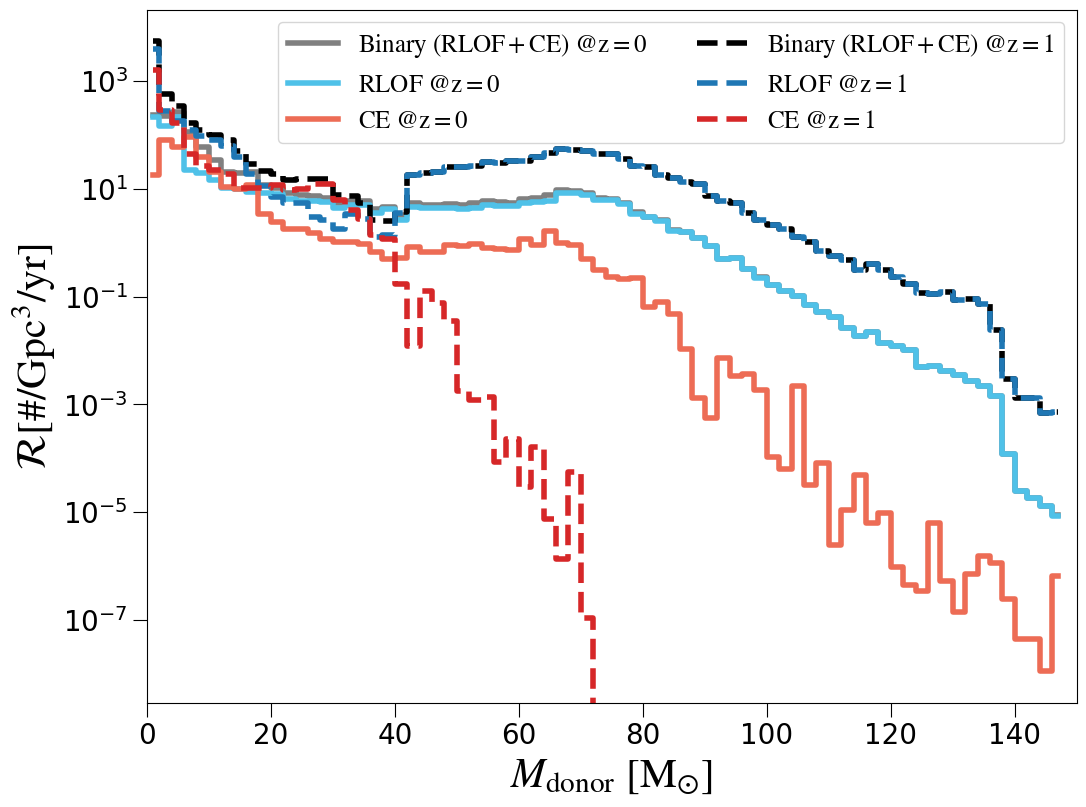

In [27]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_rate_z0_mt_aD+hist_rate_z0_ce_aD, where='mid', color=color_list[1], 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_mt_aD, where='mid', color=color_list[2], 
        label='$\mathrm{RLOF \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_ce_aD, where='mid', color=color_list[3], 
        label='$\mathrm{CE \ @z=0}$', lw=4)


ax.step(mass_center_bins, hist_rate_z1_mt_aD+hist_rate_z1_ce_aD, where='mid', color='black', 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_mt_aD, where='mid', color='tab:blue', 
        label='$\mathrm{RLOF \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_ce_aD, where='mid', color='tab:red', 
        label='$\mathrm{CE \ @z=1}$', lw=4, ls='dashed')


########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 150])
# ax.set_ylim([5e3, 2e9])

plt.xlabel(r'$M_{\mathrm{donor}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{R} \mathrm{[\# /Gpc^3 / yr]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 18, ncol=2)
plt.savefig(save_dir+'rate_distribution_aD.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

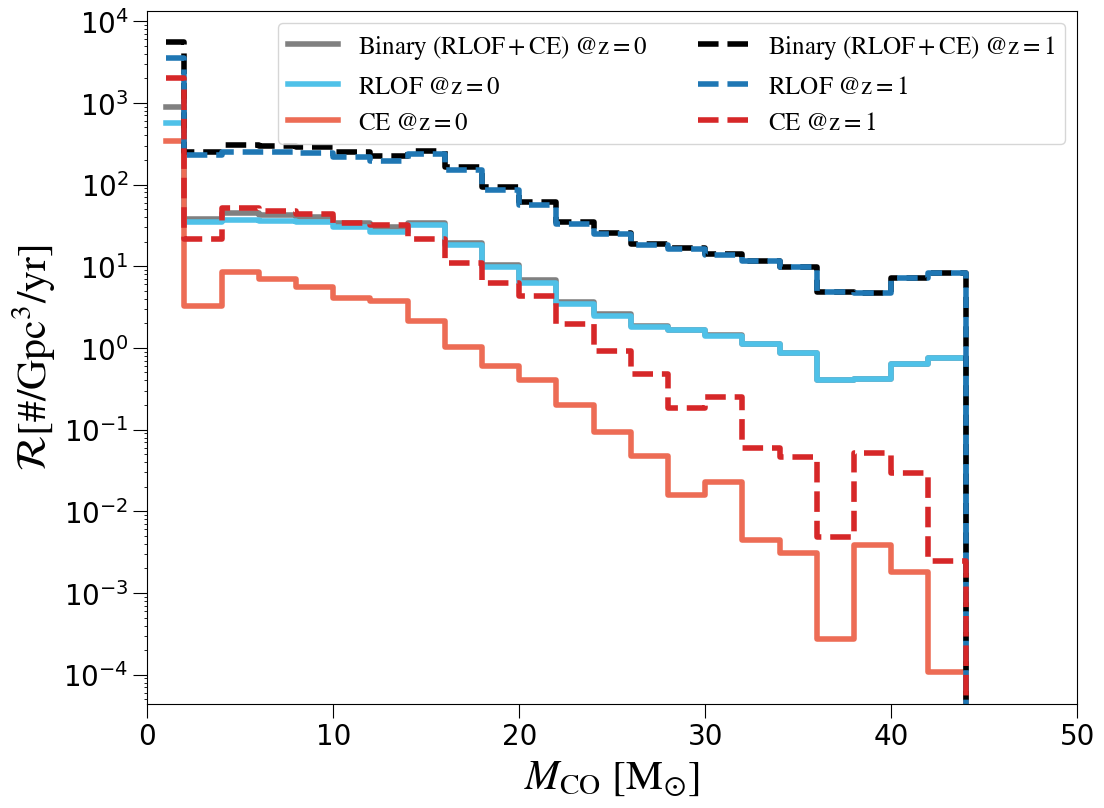

In [28]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_rate_z0_mt_A+hist_rate_z0_ce_A, where='mid', color=color_list[1], 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_mt_A, where='mid', color=color_list[2], 
        label='$\mathrm{RLOF \ @z=0}$', lw=4)
ax.step(mass_center_bins, hist_rate_z0_ce_A, where='mid', color=color_list[3], 
        label='$\mathrm{CE \ @z=0}$', lw=4)


ax.step(mass_center_bins, hist_rate_z1_mt_A+hist_rate_z1_ce_A, where='mid', color='black', 
        label=r'$\mathrm{Binary \ (RLOF+CE) \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_mt_A, where='mid', color='tab:blue', 
        label='$\mathrm{RLOF \ @z=1}$', lw=4, ls='dashed')
ax.step(mass_center_bins, hist_rate_z1_ce_A, where='mid', color='tab:red', 
        label='$\mathrm{CE \ @z=1}$', lw=4, ls='dashed')


########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 50])
# ax.set_ylim([5e3, 2e9])

plt.xlabel(r'$M_{\mathrm{CO}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{R} \mathrm{[\# /Gpc^3 / yr]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 18, ncol=2)
plt.savefig(save_dir+'rate_distribution_CO.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Metallicity Distribution

In [29]:
events_per_Zbin = Table()
Metal_bins  = np.linspace(-4, np.log10(0.03), 15)
Metal_center_bins = (Metal_bins[1:] + Metal_bins[:-1])/2.

SYS_Zbin_indices = np.digitize(np.log10(SYS['Metallicity@ZAMS(1)']), Metal_bins, right=True)
MT_Zbin_indices = np.digitize(np.log10(mt['Metallicity@ZAMS(1)']), Metal_bins, right=True)
CE_Zbin_indices = np.digitize(np.log10(ce['Metallicity@ZAMS(1)']), Metal_bins, right=True)

events_per_Zbin['SYS'] = np.bincount(SYS_Zbin_indices, weights=SYS['mixture_weight'])[1:]
events_per_Zbin['MT'] = np.bincount(MT_Zbin_indices, weights=mt['mixture_weight'])[1:]
events_per_Zbin['CE'] = np.bincount(CE_Zbin_indices, weights=ce['mixture_weight'])[1:]

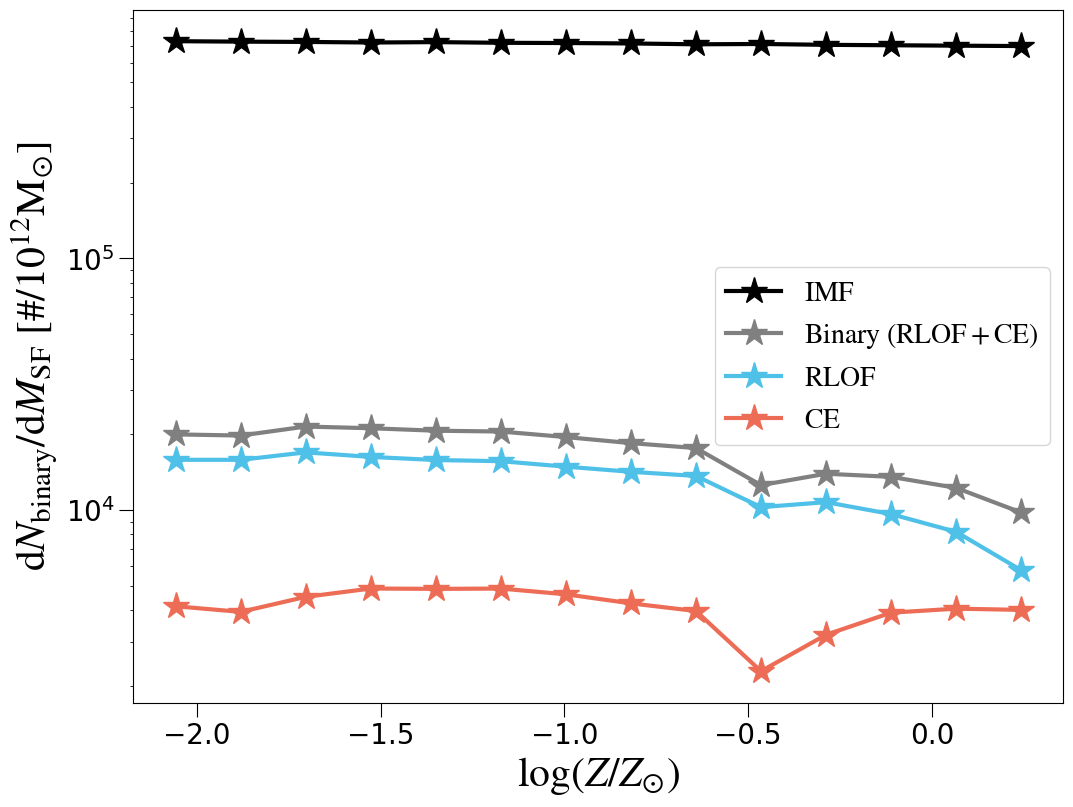

In [30]:
# Then plot it!
####################
color_list = ['black', 'grey', '#4FC1E8', '#ed6c55', '#A0D568', '#FFCE54', '#6e6e6e']


fig, ax = plt.subplots(figsize = (12,9))

plt.plot(np.log10((10**Metal_center_bins)/Zsun), events_per_Zbin['SYS'],
             marker = '*', c = color_list[0], label = r'$\mathrm{IMF}$', lw = 3, markersize = 20)
plt.plot(np.log10((10**Metal_center_bins)/Zsun), events_per_Zbin['MT']+events_per_Zbin['CE'],
             marker = '*', c = color_list[1], label = r'$\mathrm{Binary \ (RLOF+CE)}$', lw = 3, markersize = 20)
plt.plot(np.log10((10**Metal_center_bins)/Zsun), events_per_Zbin['MT'],
             marker = '*', c = color_list[2], label = r'$\mathrm{RLOF}$', lw = 3, markersize = 20)
plt.plot(np.log10((10**Metal_center_bins)/Zsun), events_per_Zbin['CE'],
             marker = '*', c = color_list[3], label = r'$\mathrm{CE}$', lw = 3, markersize = 20)

########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

plt.xlabel('$\log (Z/Z_{\odot})$', fontsize = 30)
plt.ylabel(r'$\mathrm{d} N_{\mathrm{binary}} / \mathrm{d}M_{\mathrm{SF}} \ \mathrm{[\# /10^{12}M_{\odot}]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 20, ncol=1)
plt.savefig(save_dir+'metalicity_distribution.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [31]:
mt_logZ_m15 = mt[np.log10(mt['Metallicity@ZAMS(1)']/Zsun) <= -1.5]
mt_logZ_m15_m05 = mt[np.logical_and(np.log10(mt['Metallicity@ZAMS(1)']/Zsun) > -1.5, np.log10(mt['Metallicity@ZAMS(1)']/Zsun) <= -0.5)]
mt_logZ_m05 = mt[np.log10(mt['Metallicity@ZAMS(1)']/Zsun) > -0.5]

ce_logZ_m15 = ce[np.log10(ce['Metallicity@ZAMS(1)']/Zsun) <= -1.5]
ce_logZ_m15_m05 = ce[np.logical_and(np.log10(ce['Metallicity@ZAMS(1)']/Zsun) > -1.5, np.log10(ce['Metallicity@ZAMS(1)']/Zsun) <= -0.5)]
ce_logZ_m05 = ce[np.log10(ce['Metallicity@ZAMS(1)']/Zsun) > -0.5]


mt_logZ_40_30 = mt[np.logical_and(mt['Metallicity@ZAMS(1)'] > 10**-4, mt['Metallicity@ZAMS(1)'] <= 10**-3)]
mt_logZ_30_25 = mt[np.logical_and(mt['Metallicity@ZAMS(1)'] > 10**-3, mt['Metallicity@ZAMS(1)'] <= 10**-2.5)]
mt_logZ_25_20 = mt[np.logical_and(mt['Metallicity@ZAMS(1)'] > 10**-2.5, mt['Metallicity@ZAMS(1)'] <= 10**-2)]
mt_logZ_20_15 = mt[np.logical_and(mt['Metallicity@ZAMS(1)'] > 10**-2, mt['Metallicity@ZAMS(1)'] <= 10**-1.5)]

ce_logZ_40_30 = ce[np.logical_and(ce['Metallicity@ZAMS(1)'] > 10**-4, ce['Metallicity@ZAMS(1)'] <= 10**-3)]
ce_logZ_30_25 = ce[np.logical_and(ce['Metallicity@ZAMS(1)'] > 10**-3, ce['Metallicity@ZAMS(1)'] <= 10**-2.5)]
ce_logZ_25_20 = ce[np.logical_and(ce['Metallicity@ZAMS(1)'] > 10**-2.5, ce['Metallicity@ZAMS(1)'] <= 10**-2)]
ce_logZ_20_15 = ce[np.logical_and(ce['Metallicity@ZAMS(1)'] > 10**-2, ce['Metallicity@ZAMS(1)'] <= 10**-1.5)]

In [32]:
hist_rate_mt_logZ_m15_A_z0, bin_edge = np.histogram(mt_logZ_m15['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_m15['rate_z0'])
hist_rate_mt_logZ_m15_m05_A_z0, bin_edge = np.histogram(mt_logZ_m15_m05['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_m15_m05['rate_z0'])
hist_rate_mt_logZ_m05_A_z0, bin_edge = np.histogram(mt_logZ_m05['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_m05['rate_z0'])

hist_rate_ce_logZ_m15_A_z0, bin_edge = np.histogram(ce_logZ_m15['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_m15['rate_z0'])
hist_rate_ce_logZ_m15_m05_A_z0, bin_edge = np.histogram(ce_logZ_m15_m05['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_m15_m05['rate_z0'])
hist_rate_ce_logZ_m05_A_z0, bin_edge = np.histogram(ce_logZ_m05['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_m05['rate_z0'])


hist_rate_mt_logZ_m15_A_z1, bin_edge = np.histogram(mt_logZ_m15['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_m15['rate_z1'])
hist_rate_mt_logZ_m15_m05_A_z1, bin_edge = np.histogram(mt_logZ_m15_m05['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_m15_m05['rate_z1'])
hist_rate_mt_logZ_m05_A_z1, bin_edge = np.histogram(mt_logZ_m05['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_m05['rate_z1'])

hist_rate_ce_logZ_m15_A_z1, bin_edge = np.histogram(ce_logZ_m15['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_m15['rate_z1'])
hist_rate_ce_logZ_m15_m05_A_z1, bin_edge = np.histogram(ce_logZ_m15_m05['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_m15_m05['rate_z1'])
hist_rate_ce_logZ_m05_A_z1, bin_edge = np.histogram(ce_logZ_m05['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_m05['rate_z1'])




hist_rate_mt_logZ_40_30_A_z0, bin_edge = np.histogram(mt_logZ_40_30['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_40_30['rate_z0'])
hist_rate_mt_logZ_30_25_A_z0, bin_edge = np.histogram(mt_logZ_30_25['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_30_25['rate_z0'])
hist_rate_mt_logZ_25_20_A_z0, bin_edge = np.histogram(mt_logZ_25_20['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_25_20['rate_z0'])
hist_rate_mt_logZ_20_15_A_z0, bin_edge = np.histogram(mt_logZ_20_15['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_20_15['rate_z0'])

hist_rate_ce_logZ_40_30_A_z0, bin_edge = np.histogram(ce_logZ_40_30['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_40_30['rate_z0'])
hist_rate_ce_logZ_30_25_A_z0, bin_edge = np.histogram(ce_logZ_30_25['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_30_25['rate_z0'])
hist_rate_ce_logZ_25_20_A_z0, bin_edge = np.histogram(ce_logZ_25_20['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_25_20['rate_z0'])
hist_rate_ce_logZ_20_15_A_z0, bin_edge = np.histogram(ce_logZ_20_15['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_20_15['rate_z0'])


hist_rate_mt_logZ_40_30_A_z1, bin_edge = np.histogram(mt_logZ_40_30['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_40_30['rate_z1'])
hist_rate_mt_logZ_30_25_A_z1, bin_edge = np.histogram(mt_logZ_30_25['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_30_25['rate_z1'])
hist_rate_mt_logZ_25_20_A_z1, bin_edge = np.histogram(mt_logZ_25_20['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_25_20['rate_z1'])
hist_rate_mt_logZ_20_15_A_z1, bin_edge = np.histogram(mt_logZ_20_15['Mass(A)<MT'], bins=mass_bins, weights=mt_logZ_20_15['rate_z1'])

hist_rate_ce_logZ_40_30_A_z1, bin_edge = np.histogram(ce_logZ_40_30['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_40_30['rate_z1'])
hist_rate_ce_logZ_30_25_A_z1, bin_edge = np.histogram(ce_logZ_30_25['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_30_25['rate_z1'])
hist_rate_ce_logZ_25_20_A_z1, bin_edge = np.histogram(ce_logZ_25_20['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_25_20['rate_z1'])
hist_rate_ce_logZ_20_15_A_z1, bin_edge = np.histogram(ce_logZ_20_15['Mass(A)<MT'], bins=mass_bins, weights=ce_logZ_20_15['rate_z1'])

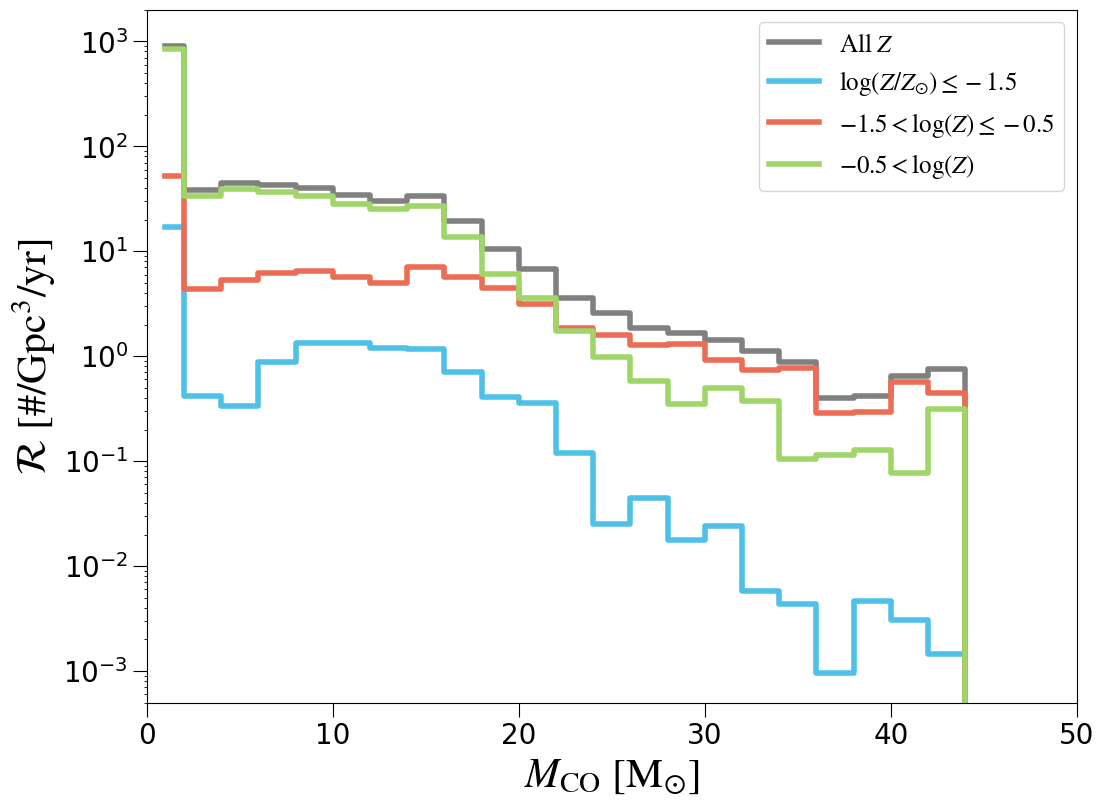

In [33]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))


ax.step(mass_center_bins, (hist_rate_z0_mt_A+hist_rate_z0_ce_A), where='mid', color=color_list[1], 
        label=r'$\mathrm{All} \ Z$', lw=4)
ax.step(mass_center_bins, (hist_rate_mt_logZ_m15_A_z0+hist_rate_ce_logZ_m15_m05_A_z0), where='mid', color=color_list[2], 
        label=r'$\log(Z/Z_{\odot}) \leq -1.5$', lw=4)
ax.step(mass_center_bins, (hist_rate_mt_logZ_m15_m05_A_z0+hist_rate_ce_logZ_m15_m05_A_z0), where='mid', color=color_list[3], 
        label=r'$-1.5 < \log(Z) \leq -0.5$', lw=4)
ax.step(mass_center_bins, (hist_rate_mt_logZ_m05_A_z0+hist_rate_ce_logZ_m05_A_z0), where='mid', color=color_list[4], 
        label=r'$-0.5 < \log(Z)$', lw=4)

# ax.step(mass_center_bins, (hist_rate_z0_mt_A+hist_rate_z0_ce_A), where='mid', color=color_list[1], 
#         label=r'$\mathrm{All} \ Z$', lw=4)
# ax.step(mass_center_bins, (hist_rate_mt_logZ_40_30_A_z0+hist_rate_ce_logZ_40_30_A_z0), where='mid', color=color_list[2], 
#         label=r'$-4 < \log(Z) < -3$', lw=4)
# ax.step(mass_center_bins, (hist_rate_mt_logZ_30_25_A_z0+hist_rate_ce_logZ_30_25_A_z0), where='mid', color=color_list[3], 
#         label=r'$-3 < \log(Z) < -2.5$', lw=4)
# ax.step(mass_center_bins, (hist_rate_mt_logZ_25_20_A_z0+hist_rate_ce_logZ_25_20_A_z0), where='mid', color=color_list[4], 
#         label=r'$-2.5 < \log(Z) < -2.0$', lw=4)
# ax.step(mass_center_bins, (hist_rate_mt_logZ_20_15_A_z0+hist_rate_ce_logZ_20_15_A_z0), where='mid', color=color_list[5], 
#         label=r'$-2.0 < \log(Z) < -1.5$', lw=4)


########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 50])
ax.set_ylim([5e-4, 2e3])

plt.xlabel(r'$M_{\mathrm{CO}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{R} \ \mathrm{[\# /Gpc^3 / yr]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 18, ncol=1)
plt.savefig(save_dir+'metallicity_distribution_CO_z0.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [34]:
hist_rate_mt_logZ_40_30, bin_edge = np.histogram(mt_logZ_40_30['Mass@ZAMS(1)'], bins=mass_bins, weights=mt_logZ_40_30['rate_z0'])
hist_rate_mt_logZ_30_25, bin_edge = np.histogram(mt_logZ_30_25['Mass@ZAMS(1)'], bins=mass_bins, weights=mt_logZ_30_25['rate_z0'])
hist_rate_mt_logZ_25_20, bin_edge = np.histogram(mt_logZ_25_20['Mass@ZAMS(1)'], bins=mass_bins, weights=mt_logZ_25_20['rate_z0'])
hist_rate_mt_logZ_20_15, bin_edge = np.histogram(mt_logZ_20_15['Mass@ZAMS(1)'], bins=mass_bins, weights=mt_logZ_20_15['rate_z0'])

hist_rate_ce_logZ_40_30, bin_edge = np.histogram(ce_logZ_40_30['Mass@ZAMS(1)'], bins=mass_bins, weights=ce_logZ_40_30['rate_z0'])
hist_rate_ce_logZ_30_25, bin_edge = np.histogram(ce_logZ_30_25['Mass@ZAMS(1)'], bins=mass_bins, weights=ce_logZ_30_25['rate_z0'])
hist_rate_ce_logZ_25_20, bin_edge = np.histogram(ce_logZ_25_20['Mass@ZAMS(1)'], bins=mass_bins, weights=ce_logZ_25_20['rate_z0'])
hist_rate_ce_logZ_20_15, bin_edge = np.histogram(ce_logZ_20_15['Mass@ZAMS(1)'], bins=mass_bins, weights=ce_logZ_20_15['rate_z0'])

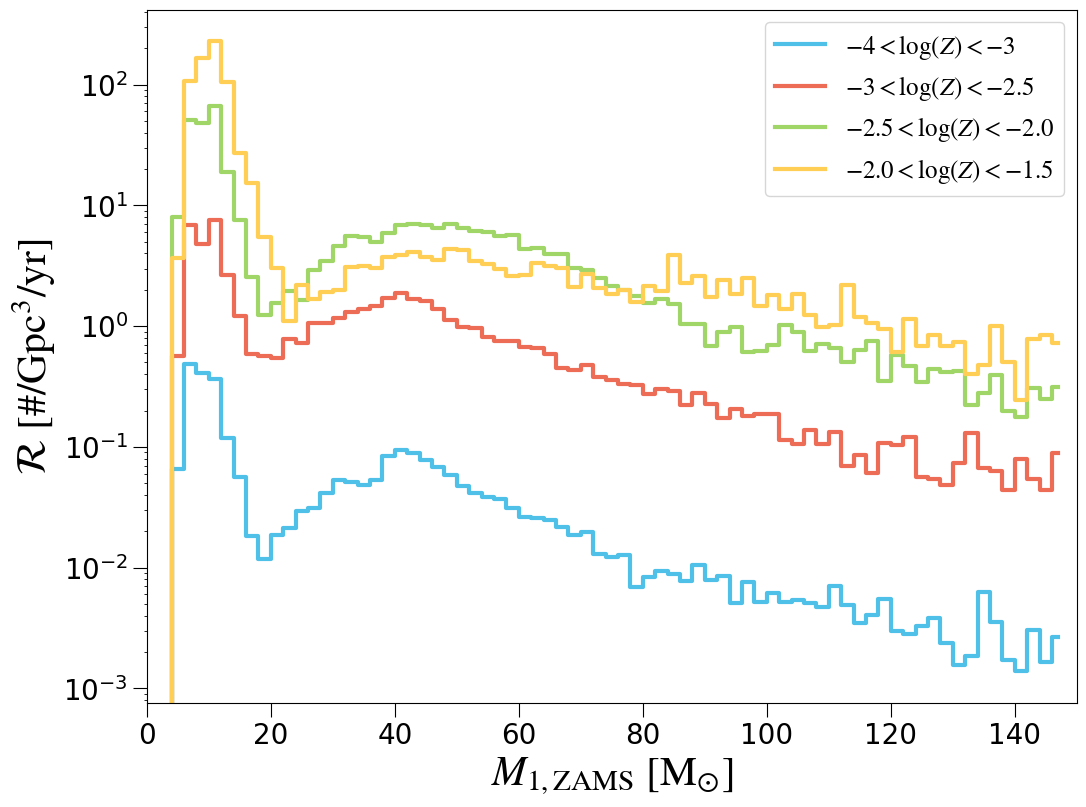

In [35]:
# Then plot it!
####################
fig, ax = plt.subplots(figsize = (12,9))

ax.step(mass_center_bins, hist_rate_mt_logZ_40_30+hist_rate_ce_logZ_40_30, where='mid', color=color_list[2], 
        label=r'$-4 < \log(Z) < -3$', lw=3)
ax.step(mass_center_bins, hist_rate_mt_logZ_30_25+hist_rate_ce_logZ_30_25, where='mid', color=color_list[3], 
        label=r'$-3 < \log(Z) < -2.5$', lw=3)
ax.step(mass_center_bins, hist_rate_mt_logZ_25_20+hist_rate_ce_logZ_25_20, where='mid', color=color_list[4], 
        label=r'$-2.5 < \log(Z) < -2.0$', lw=3)
ax.step(mass_center_bins, hist_rate_mt_logZ_20_15+hist_rate_ce_logZ_20_15, where='mid', color=color_list[5], 
        label=r'$-2.0 < \log(Z) < -1.5$', lw=3)


########
ax.tick_params(axis='both', which='major', labelsize=20, size=10)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.locator_params(axis='y', nbins=6)

ax.set_xlim([0.0, 150])
# ax.set_ylim([5e3, 2e9])

plt.xlabel(r'$M_{\mathrm{1, ZAMS}} \ {\mathrm{[M_{\odot}]}}$', fontsize = 30)
plt.ylabel(r'$\mathcal{R} \ \mathrm{[\# /Gpc^3 / yr]}$', fontsize = 30)

plt.yscale('log')
plt.legend(fontsize = 18, ncol=1)
plt.savefig(save_dir+'metallicity_distribution_zams.pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()

## Mdot - t Diagram

In [36]:
def plot_mdot_t (hist, mdot_edges, t_edges, output, Colormap='viridis', grid=False):
    
    fig, ax = plt.subplots(figsize = (12,8))
    
    pcm = ax.pcolormesh(np.log10(mdot_edges), np.log10(t_edges*Myr/yr), hist.T, cmap=Colormap, norm=LogNorm())
    cbar = plt.colorbar(pcm, ax=ax, pad=0.01) 
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(label=r'$\mathcal{R} \ \mathrm{[\# /Gpc^3 / yr]}$', fontsize=30)
    
    plt.xlim(np.min(np.log10(mdot_edges)), np.max(np.log10(mdot_edges)))
    plt.ylim(np.min(np.log10(t_edges*Myr/yr)), np.max(np.log10(t_edges*Myr/yr)))
    
    # plt.scatter(np.log10(mdot_center), np.log10(t_center))
    
    if grid==True:
        for i in range(len(mdot_edges)):
            plt.axvline(np.log10(mdot_edges[i]), color='gray')
    
        for i in range(len(t_edges)):
            plt.axhline(np.log10(t_edges[i]*Myr/yr), color='gray')
    
    ########
    ax.tick_params(axis='both', which='major', labelsize=20, size=20)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.locator_params(axis='y', nbins=7)
    
    plt.xlabel(r'$\log({\dot{M} / \dot{M}_{\mathrm{Edd}}})$', fontsize = 30)
    plt.ylabel(r'$\log({t_{\mathrm{acc}}} \ {\rm ~[yr]})$', fontsize = 30)
    
    plt.savefig(save_dir+output, bbox_inches='tight', pad_inches=0.1)


    plt.show()

    return

In [37]:
mt_mdot_min = mt['Eddington'].min()
mt_mdot_max = mt['Eddington'].max()
ce_mdot_min = ce['Eddington'].min()
ce_mdot_max = ce['Eddington'].max()

mt_t_min = mt['Timescale'].min()
mt_t_max = mt['Timescale'].max()
ce_t_min = ce['Timescale'].min()
ce_t_max = ce['Timescale'].max()

print(f'MT Mdot Min: {mt_mdot_min:.2E}')
print(f'MT Mdot Max: {mt_mdot_max:.2E}')
print(f'CE Mdot Min: {ce_mdot_min:.2E}')
print(f'CE Mdot Max: {ce_mdot_max:.2E}')

print(f'MT t Min: {mt_t_min:.2E}')
print(f'MT t Max: {mt_t_max:.2E}')
print(f'CE t Min: {ce_t_min:.2E}')
print(f'CE t Max: {ce_t_max:.2E}')

MT Mdot Min: 1.00E+02
MT Mdot Max: 1.31E+08
CE Mdot Min: 1.00E+02
CE Mdot Max: 4.92E+08
MT t Min: 1.00E-06
MT t Max: 6.24E-01
CE t Min: 3.67E-07
CE t Max: 3.17E+00


In [38]:
mdot_bin = np.logspace(np.log10(1e2), np.log10(ce_mdot_max), 21)
t_bin = np.logspace(np.log10(ce_t_min), np.log10(ce_t_max), 19)
    
hist_mt_z0, mdot_edges, t_edges = np.histogram2d(mt['Eddington'], mt['Timescale'], 
                                              bins=(mdot_bin, t_bin), weights=mt['rate_z0'])
hist_ce_z0, mdot_edges, t_edges = np.histogram2d(ce['Eddington'], ce['Timescale'], 
                                              bins=(mdot_bin, t_bin), weights=ce['rate_z0'])

hist_mt_z1, mdot_edges, t_edges = np.histogram2d(mt['Eddington'], mt['Timescale'], 
                                              bins=(mdot_bin, t_bin), weights=mt['rate_z1'])
hist_ce_z1, mdot_edges, t_edges = np.histogram2d(ce['Eddington'], ce['Timescale'], 
                                              bins=(mdot_bin, t_bin), weights=ce['rate_z1'])

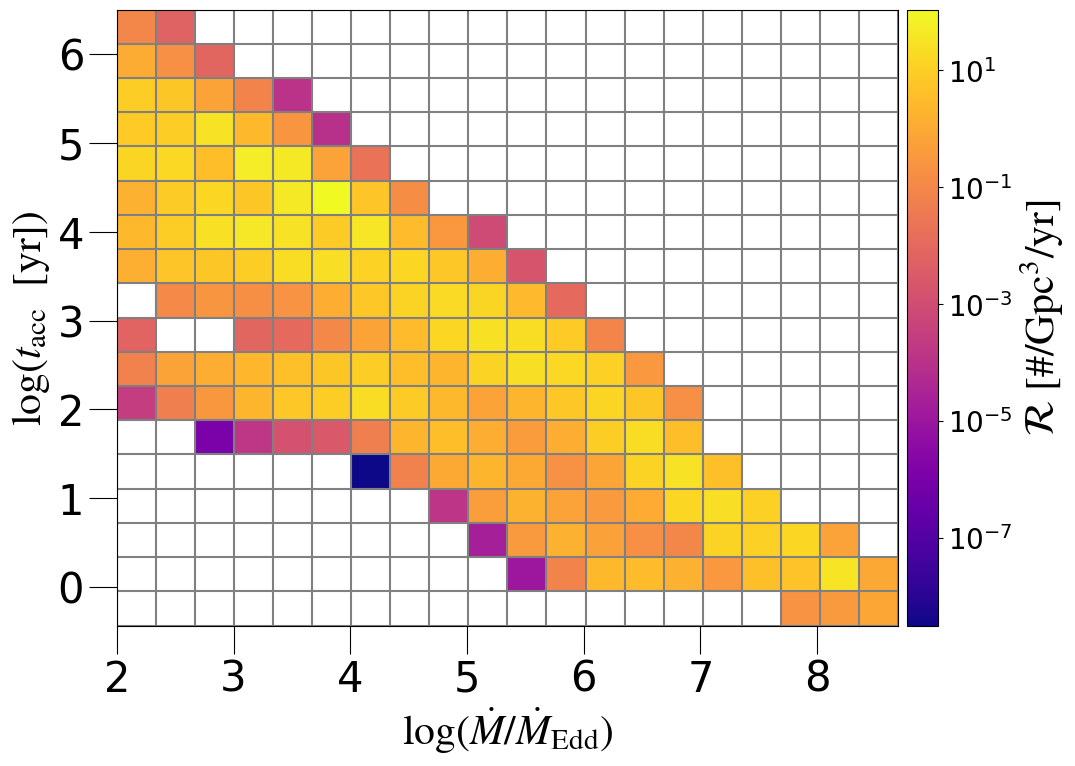

In [39]:
plot_mdot_t((hist_mt_z0+hist_ce_z0), mdot_bin, t_bin, 'mdot_t_distribution_z0.pdf', Colormap='plasma', grid=True)

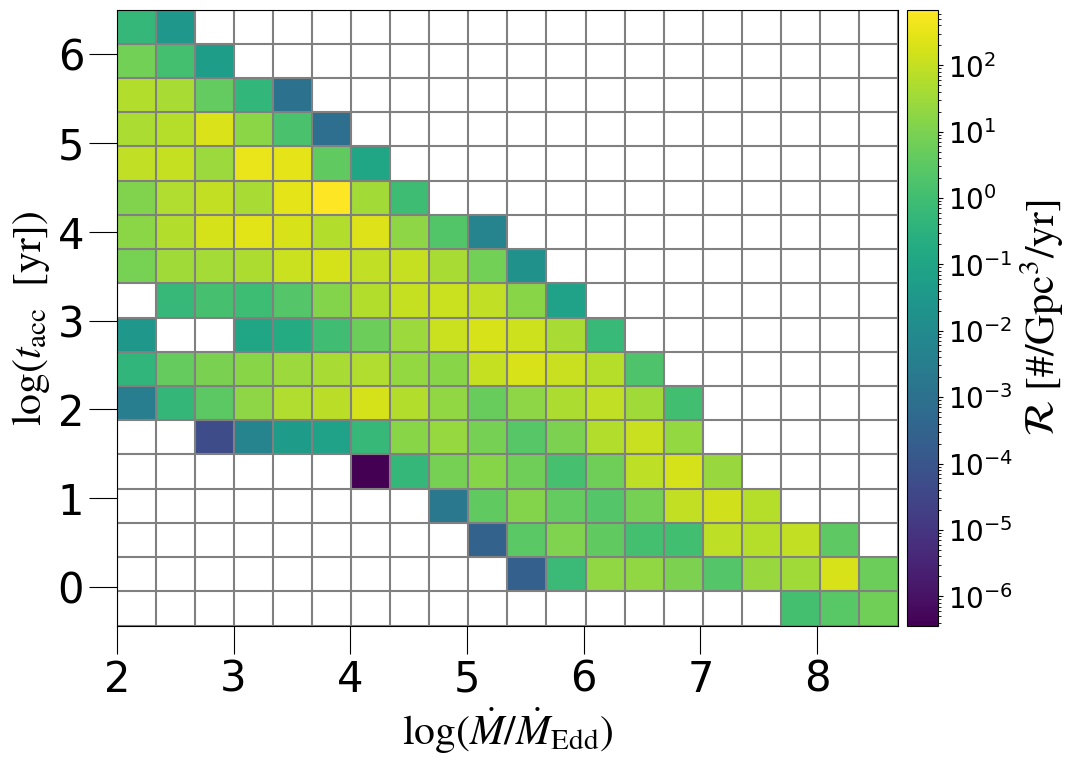

In [40]:
plot_mdot_t((hist_mt_z1+hist_ce_z1), mdot_bin, t_bin, 'mdot_t_distribution_z1.pdf', Colormap='viridis', grid=True)